# Hyperparameter Tuning: Optimizing Model Performance

Machine learning models often have parameters that are **not learned from the data** but are set by the user *before* training begins. These are called **hyperparameters**. The choice of hyperparameters can significantly impact a model's performance.

For example, in the K-Nearest Neighbors (KNN) model, the number of neighbors (`n_neighbors`) is a hyperparameter. Choosing `n_neighbors=3` might work well, but would `n_neighbors=5` or `n_neighbors=10` yield better results?

**Hyperparameter tuning** is the process of finding the optimal set of hyperparameters for a given model and dataset. The goal is to maximize the model's performance on *unseen* data.

A common approach is **Grid Search**. This involves:

1.  Defining a grid of possible values for each hyperparameter you want to tune.
2.  Training and evaluating the model for every possible combination of hyperparameter values in the grid.
3.  Identifying the combination that yields the best performance (typically measured using cross-validation on the training data).

Scikit-learn provides tools like `GridSearchCV` to automate this process. It systematically explores the grid and handles the cross-validation to find the best parameters.

In [37]:
# import the modules

import time
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)
import matplotlib.pyplot as plt

In [15]:
# Load the preprocessed data
df = pd.read_csv("data/sdss_photoz_clean.csv")

df['u-g'] = df['u'] - df['g']
df['g-r'] = df['g'] - df['r']
df['r-i'] = df['r'] - df['i']
df['i-z'] = df['i'] - df['z']

# Features: color indices; Target: redshift
X = df[['u-g', 'g-r', 'r-i', 'i-z']].values
y = df['redshift'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## Cross-Validation with KFold and Grid Search

### What is Cross-Validation?

Cross-validation is a model validation technique used to assess how a predictive model generalizes to an independent dataset. It helps detect issues like overfitting or underfitting by splitting the data into training and validation sets multiple times in a systematic way.

---

### KFold Cross-Validation

**KFold** (K-Folds cross-validation) divides the dataset into *K* equal-sized folds. The model is trained on *K-1* folds and validated on the remaining fold. This process is repeated *K* times so that each fold serves as a validation set once.

**How it works:**

- Split data into `K` subsets (folds)
- Train the model on `K-1` folds
- Validate on the remaining fold
- Repeat the process for all `K` folds
- Average the performance metrics across all folds

**Advantages:**

- More robust estimate of model performance
- Reduces variance compared to a single train-test split
- Ensures that every data point is used for validation

---

### Grid Search with Cross-Validation

**GridSearchCV** performs an exhaustive search over a specified parameter grid by:

1. Trying all possible combinations of hyperparameters.
2. Performing cross-validation (e.g., using KFold) for each combination.
3. Selecting the combination that yields the best cross-validated performance.

**Key Parameters:**

- `param_grid`: A dictionary defining which parameters and values to try.
- `cv`: The cross-validation strategy (e.g., `KFold(n_splits=5)`).
- `scoring`: A string or dictionary of scoring metrics (e.g., `'r2'`, `'neg_mean_squared_error'`).
- `refit`: Which scoring metric to use for choosing the best model.

---

For more on cross validation, check out the sklearn documentation: <https://scikit-learn.org/stable/modules/cross_validation.html>

Let's try out an example for KNNRegressor, See <https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html> for more details

In [9]:
# Intialise the KNN regressor class
knn = KNeighborsRegressor()

In [33]:
# Define the hyperparameter grid
param_grid = {
    'n_neighbors': list(range(1, 51, 2)),       # odd values from 1 to 49
    'weights': ['uniform', 'distance'],
    'p': [1, 2],                                # 1: Manhattan, 2: Euclidean
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Cross-validation strategy (reproducible splits)
cv = KFold(n_splits=20, shuffle=True, random_state=42)

# Multiple scoring metrics
scoring = {
    'neg_mse': 'neg_mean_squared_error',
    'neg_mae': 'neg_mean_absolute_error',
    'r2': 'r2'
}

# Grid search with multiple scorers
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring=scoring,
    refit='r2',         # refit based on R² score
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search

GridSearchCV(cv=KFold(n_splits=20, random_state=42, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             refit='r2',
             scoring={'neg_mae': 'neg_mean_absolute_error',
                      'neg_mse': 'neg_mean_squared_error', 'r2': 'r2'},
             verbose=1)

In [34]:
# Start timing
start_time = time.time()

# Fit the model
grid_search.fit(X_train, y_train)

# End timing
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nGrid search took {elapsed_time:.2f} seconds.")


Fitting 20 folds for each of 400 candidates, totalling 8000 fits

Grid search took 27.44 seconds.


Best Parameters:
{'algorithm': 'brute', 'n_neighbors': 13, 'p': 2, 'weights': 'distance'}

Test Set Evaluation:
R² Score: 0.8559
Mean Squared Error (MSE): 0.0294
Mean Absolute Error (MAE): 0.0555


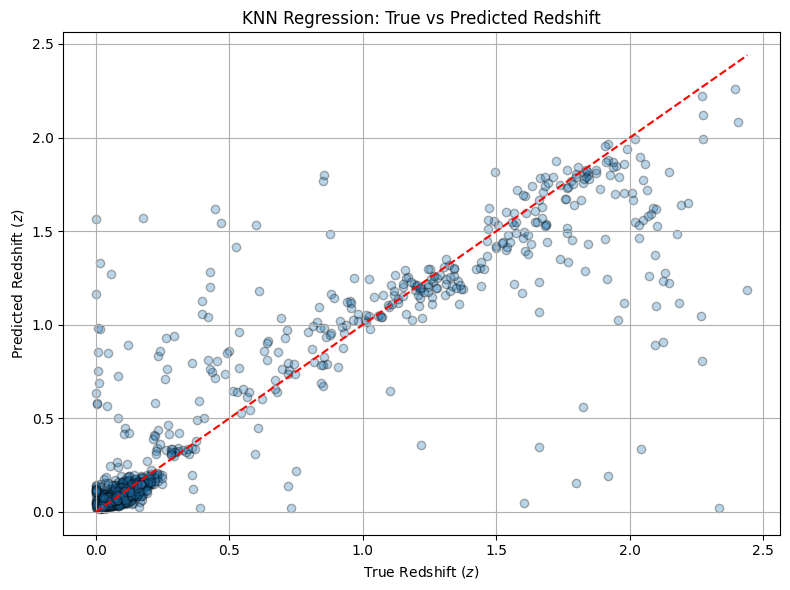

In [28]:
# Best model
best_knn = grid_search.best_estimator_
print("Best Parameters:")
print(grid_search.best_params_)

# Predict on test set
y_pred = best_knn.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Set Evaluation:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Plot: True vs Predicted Redshifts
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3, edgecolors='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel(r"True Redshift ($z$)")
plt.ylabel(r"Predicted Redshift ($z$)")
plt.title("KNN Regression: True vs Predicted Redshift")
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# Get best parameters from grid search
knn_params = grid_search.best_params_

# Create a new RandomForestRegressor with the best params and the same random_state
knn_model = KNeighborsRegressor(**knn_params,)

# Retrain the model on the full training data
knn_model.fit(X_train, y_train)

# Predict on test set
y_pred = knn_model.predict(X_test)

# Evaluate predictions
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Evaluation after retraining with best parameters:")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.4f}")


Evaluation after retraining with best parameters:
R² Score: 0.8559
Mean Squared Error: 0.0294
Mean Absolute Error: 0.0555


## Random Forest
Let's try for Random Forest Regressor, see <https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html> for more details.

In [29]:
# Set up Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
}

# Cross-validation strategy (reproducible splits)
cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Grid search with multiple scoring metrics
scoring = {
    'neg_mse': 'neg_mean_squared_error',
    'neg_mae': 'neg_mean_absolute_error',
    'r2': 'r2'
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=scoring,
    refit='r2',         # refit based on R² score
    cv=cv,
    n_jobs=4,
    verbose=1
)

grid_search

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=42), n_jobs=4,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             refit='r2',
             scoring={'neg_mae': 'neg_mean_absolute_error',
                      'neg_mse': 'neg_mean_squared_error', 'r2': 'r2'},
             verbose=1)

In [30]:
# Start timing
start_time = time.time()

# Fit the model
grid_search.fit(X_train, y_train)

# End timing
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nGrid search took {elapsed_time:.2f} seconds.")

Fitting 3 folds for each of 324 candidates, totalling 972 fits


/Users/user1/Data/brics_astro/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
324 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
324 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/user1/Data/brics_astro/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/user1/Data/brics_astro/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Users/user1/Data/brics_astro/.venv/lib/python3.10/site-packages/sklearn/base.py", line 436, in _validate_par


Grid search took 243.98 seconds.


Best Parameters Found:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

Test Set Evaluation:
R² Score: 0.8515
Mean Squared Error (MSE): 0.0303
Mean Absolute Error (MAE): 0.0574


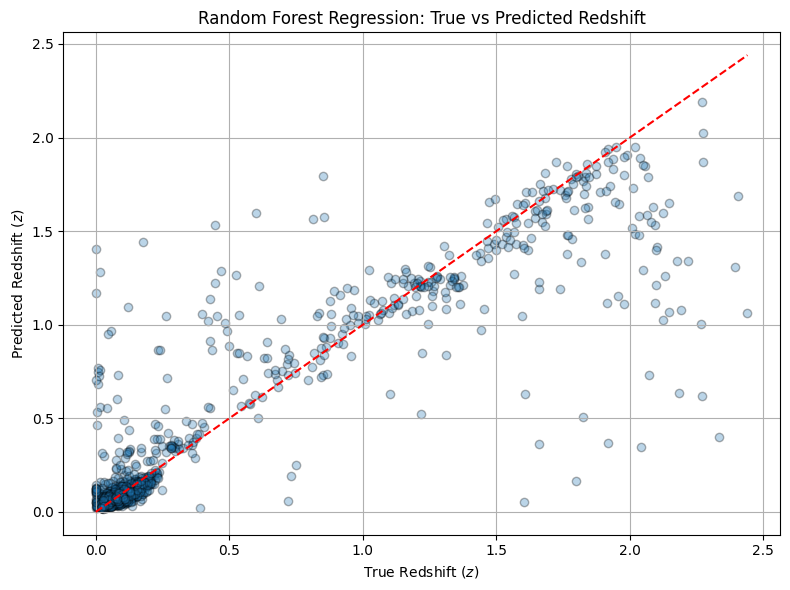

In [31]:
# Get best model
best_rf = grid_search.best_estimator_
print("Best Parameters Found:")
print(grid_search.best_params_)

# Evaluate on test set
y_pred = best_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Set Evaluation:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# 11. Plot: True vs Predicted Redshifts
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3, edgecolors='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel(r"True Redshift ($z$)")
plt.ylabel(r"Predicted Redshift ($z$)")
plt.title("Random Forest Regression: True vs Predicted Redshift")
plt.grid(True)
plt.tight_layout()
plt.show()


Bear in mind that the above will take some minutes to run.

In [32]:
# Get best parameters from grid search
rf_params = grid_search.best_params_

# Create a new RandomForestRegressor with the best params and the same random_state
rf_model = RandomForestRegressor(**best_params, random_state=42)

# Retrain the model on the full training data
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Evaluate predictions
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Evaluation after retraining with best parameters:")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.4f}")


Evaluation after retraining with best parameters:
R² Score: 0.8515
Mean Squared Error: 0.0303
Mean Absolute Error: 0.0574


In [ ]:

# 5. Save the trained model to disk
model_filename = "rf_forest_model.pkl"
joblib.dump(rf_model, model_filename)

The random forest model improved from 84% in the previous notebook to 85%.

## Summary

This section introduced the concept of hyper-parmater tuning for regression problems.


We briefly demonstrated a basic workflow using the **scikit-learn** library:
*   Loading a dataset (Iris).
*   Splitting data into **training** and **test sets** to avoid overfitting and evaluate generalization.
*   Initializing a simple model (K-Nearest Neighbors).
*   **Training** the model on the training set (`.fit()`).
*   **Predicting** on the unseen test set (`.predict()`).
*   **Evaluating** model performance using metrics like **accuracy**, **precision**, **recall**, **F1-score**, and the **confusion matrix**.
*   **Saving and loading** trained models for future use.
*   The concept of **Hyperparameter Tuning** to optimize model performance and using **Grid Search** (`GridSearchCV`) to find the best parameters through systematic search and cross-validation on the training data.

This provides a foundational understanding of Machine Learning concepts and a glimpse into how libraries like scikit-learn are used to apply them, particularly relevant for the growing field of data-driven astronomy.